In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylops
from scipy.signal import butter, filtfilt
from numpy.linalg import inv
import warnings
import scienceplots
import seaborn as sns
import dask.array as da
import polars as pl
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import matplotlib.lines as mlines

warnings.filterwarnings("ignore")
# seaborn-v0_8-bright
plt.style.use(["ggplot", "science", "grid", "notebook"])
# Shades of blue
PRIMARY = "#0072b2"
PRIMARY_DARK = "#000080"
# Shades of red
SECONDARY = "#a60628"
SECONDARY_DARK = "#79011B"
# Shades of green
TERCIARY = "#228b22"
TERCIARY_DARK = "#556b2f"
# Shades of yellow
ALTERNATIVE = "#edb230"
ALTERNATIVE_DARK = "#e77728"
# Shades of black
TEXT_COLOR = "#212121"
plt.rc("font", family="Verdana")
FONT_SIZE = 16
LABEL_SIZE = 12
PARAM_SIZE = 14
VMIN = 6000
VMAX = 17000

plt.rcParams.update(
    {
        "axes.labelsize": LABEL_SIZE,
        "axes.titlesize": FONT_SIZE,
        "xtick.labelsize": LABEL_SIZE,
        "ytick.labelsize": LABEL_SIZE,
        "text.color": TEXT_COLOR,
        "axes.labelcolor": TEXT_COLOR,
        "axes.edgecolor": TEXT_COLOR,
        "xtick.color": TEXT_COLOR,
        "ytick.color": TEXT_COLOR,
        # "figure.facecolor": "white",
        # "axes.facecolor": "white",
    }
)

In [2]:
# Load the NumPy array directly
df_numpy = np.load('Uncompressed/inversion_data.npy')

# Convert the NumPy array to a Dask array
da_array = da.from_array(df_numpy, chunks=(1000000, df_numpy.shape[1]))  # Adjust chunk size as needed

# Compute the Dask array and convert to NumPy for Polars DataFrame
computed_array = da_array.compute()

# Create a Polars DataFrame
df = pl.DataFrame({
    'imp_org': computed_array[:, 0],
    'imp_back': computed_array[:, 1],
    'ricker_ML': computed_array[:, 2],
    'butter_ML': computed_array[:, 3],
    'ricker_SS': computed_array[:, 4],
    'butter_SS': computed_array[:, 5]
})

shape = (256, 256, 256)

# Reshape the computed NumPy arrays
imp_30hz = df["imp_org"].to_numpy().reshape(shape)
ricker_max_likelihood = df["ricker_ML"].to_numpy().reshape(shape)
butter_max_likelihood = df["butter_ML"].to_numpy().reshape(shape)
ricker_sparse_spike = df["ricker_SS"].to_numpy().reshape(shape)
butter_sparse_spike = df["butter_SS"].to_numpy().reshape(shape)

In [3]:
residuo_ml_ricker = df["imp_org"] - df["ricker_ML"]
residuo_ml_butter = df["imp_org"] - df["butter_ML"]
residuo_ss_ricker = df["imp_org"] - df["ricker_SS"]
residuo_ss_butter = df["imp_org"] - df["butter_SS"]

In [4]:
np.shape(imp_30hz)
0.01 * len(imp_30hz.flatten())

167772.16

In [5]:
imp_30hz_flat = imp_30hz.flatten()
ricker_max_likelihood_flat = ricker_max_likelihood.flatten()
butter_max_likelihood_flat = butter_max_likelihood.flatten()
ricker_sparse_spike_flat = ricker_sparse_spike.flatten()
butter_sparse_spike_flat = butter_sparse_spike.flatten()

sample_fraction = 0.01  # Exemplo: 0.01% dos dados
sample_indices = np.random.choice(len(imp_30hz_flat), size=int(len(imp_30hz_flat) * sample_fraction), replace=False)

imp_org_sample = imp_30hz_flat[sample_indices]
ricker_ml_sample = ricker_max_likelihood_flat[sample_indices]
butter_ml_sample = butter_max_likelihood_flat[sample_indices]
ricker_ss_sample = ricker_sparse_spike_flat[sample_indices]
butter_ss_sample = butter_sparse_spike_flat[sample_indices]

In [6]:
# Global variables
# Used in most cases

nx, ny, nz = imp_30hz.shape

import seaborn as sns
from matplotlib.ticker import ScalarFormatter

bins = 30

hist_original, bin_edges_original = np.histogram(imp_org_sample, bins=bins, density=True)

ml_hist_ricker, ml_bin_edges_ricker = np.histogram(ricker_ml_sample, bins=bins, density=True)
ml_hist_butter, ml_bin_edges_butter = np.histogram(butter_ml_sample, bins=bins, density=True)

ss_hist_ricker, ss_bin_edges_ricker = np.histogram(ricker_ss_sample, bins=bins, density=True)
ss_hist_butter, ss_bin_edges_butter = np.histogram(butter_ss_sample, bins=bins, density=True)

In [7]:
media_r_ml = np.mean(ricker_max_likelihood)
media_b_ml = np.mean(butter_max_likelihood)
media_r_ss = np.mean(ricker_sparse_spike)
media_b_ss = np.mean(butter_sparse_spike)

print(f"Media - Ricker - ML: {media_r_ml:.2f}")
print(f"Media - Butter - ML: {media_b_ml:.2f}")
print(f"Media - Ricker - SS: {media_r_ss:.2f}")
print(f"Media - Butter - SS: {media_b_ss:.2f}")

Media - Ricker - ML: 11552.68
Media - Butter - ML: 11552.68
Media - Ricker - SS: 11552.68
Media - Butter - SS: 11552.68


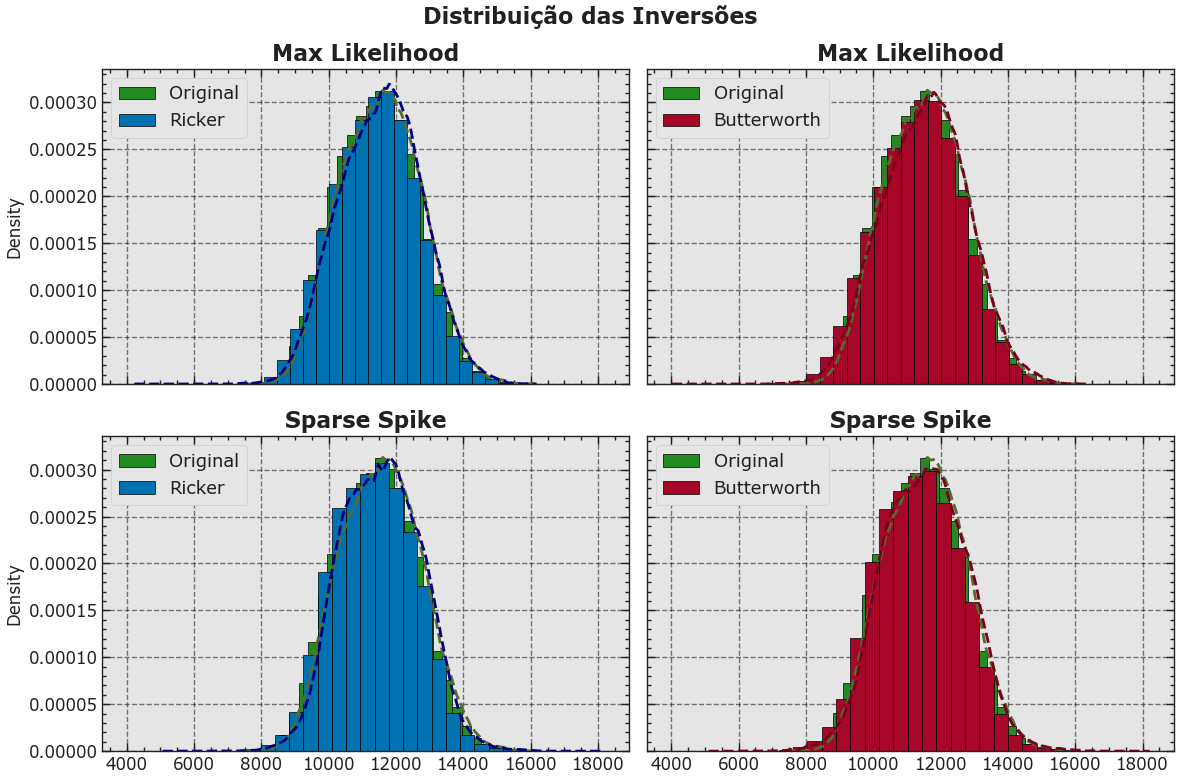

In [9]:

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)
fig.suptitle("Distribuição das Inversões", fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)

# Define a function to plot histograms and KDEs
def plot_hist_kde(ax, hist_data, bin_edges, kde_data, hist_color, kde_color, title, label):
    ax.bar(
        bin_edges[:-1], hist_data, width=np.diff(bin_edges),
        edgecolor="black", color=hist_color, alpha=1, label=label
    )
    sns.kdeplot(
        kde_data.flatten(), color=kde_color, linewidth=2,
        linestyle="--", alpha=1.0, bw_adjust=0.5, ax=ax
    )
    ax.tick_params(axis="both", labelsize=LABEL_SIZE)
    ax.set_title(title, fontsize=FONT_SIZE, fontweight="bold", color=TEXT_COLOR)
    ax.legend(loc="upper left", fontsize=FONT_SIZE - 3)

# Plot data
plot_hist_kde(axs[0, 0], hist_original, bin_edges_original, imp_org_sample, TERCIARY, TERCIARY_DARK, "Max Likelihood", "Original")
plot_hist_kde(axs[0, 0], ml_hist_ricker, ml_bin_edges_ricker, ricker_ml_sample, PRIMARY, PRIMARY_DARK, "Max Likelihood", "Ricker")

plot_hist_kde(axs[0, 1], hist_original, bin_edges_original, imp_org_sample, TERCIARY, TERCIARY_DARK, "Max Likelihood", "Original")
plot_hist_kde(axs[0, 1], ml_hist_butter, ml_bin_edges_butter, butter_ml_sample, SECONDARY, SECONDARY_DARK, "Max Likelihood", "Butterworth")

plot_hist_kde(axs[1, 0], hist_original, bin_edges_original, imp_org_sample, TERCIARY, TERCIARY_DARK, "Sparse Spike", "Original")
plot_hist_kde(axs[1, 0], ss_hist_ricker, ss_bin_edges_ricker, ricker_ss_sample, PRIMARY, PRIMARY_DARK, "Sparse Spike", "Ricker")

plot_hist_kde(axs[1, 1], hist_original, bin_edges_original, imp_org_sample, TERCIARY, TERCIARY_DARK, "Sparse Spike", "Original")
plot_hist_kde(axs[1, 1], ss_hist_butter, ss_bin_edges_butter, butter_ss_sample, SECONDARY, SECONDARY_DARK, "Sparse Spike", "Butterworth")

# axs[0, 0].vlines(x=media_r_ml, ymin=0, ymax=0.00035, color="black")
# axs[0, 1].vlines(x=media_b_ml, ymin=0, ymax=0.00035, color="black")
# axs[1, 0].vlines(x=media_r_ss, ymin=0, ymax=0.00035, color="black")
# axs[1, 1].vlines(x=media_b_ss, ymin=0, ymax=0.00035, color="black")

plt.tight_layout()
plt.savefig("Figures/stats/histograma_pesado.png", dpi=500, bbox_inches="tight")
plt.show()

Media - Ricker - ML: 11552.68
Media - Butter - ML: 11552.68
Media - Ricker - SS: 11552.68
Media - Butter - SS: 11552.68


11552.682339183724

In [11]:
a = np.array([
    [1, 2, 3],
    [4, 5, 6]
])

In [16]:
a @ 3

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [24]:
a = (2 ,3)

type(a)

tuple

In [ ]:

import numpy as np

def binarySearch(A, T):
    n = len(A)
    L = 0
    R = n - 1

    while L <= R:
        m = int(np.floor((L + R) / 2))
        if A[m] < T:
            L = m + 1
        elif A[m] > T:
            R = m - 1

        else:
            return m

    return "Unsuccessful"

# Example

M = np.array([13, 7, 22, 34, 11, 3])
M.sort()
print(M)

number = 34
result = binarySearch(M, number)

print(f"The value of {number} is in index [{result}].")


[ 3  7 11 13 22 34]
3
5
The value of 34 is in index [5].
